In [ ]:
import argparse
import awkward as ak
import copy

from copy import deepcopy
from dotenv import find_dotenv, load_dotenv
import fastjet
import h5py

import json
import logging
import math
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

import os
import os.path as osp
import pandas as pd
from pathlib import Path
import pickle as pkl
import sys
import time

import torch
import torch.cuda.amp as amp
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data import Dataset
from torchvision import models

from tqdm import tqdm
import vector
import yaml

In [5]:
save_path = "../data/val"
with h5py.File(f'{save_path}/val_20_30.h5', 'r') as hdf:
        # Access the dataset containing your JSON strings
    dataset = hdf["subjets"]
    
    # Initialize a list to hold the deserialized subjets data
    subjets_data = []
    particles_features = hdf["particles"]["features"][:]
    particles_labels = hdf["particles"]["labels"][:]
    
    # Iterate over each JSON string in the dataset
    for json_str in dataset:
        # Deserialize the JSON string to a Python object
        subjet = json.loads(json_str)
        subjets_data.append(subjet)

# At this point, `subjets_data` contains all your subjets as Python dictionaries

In [6]:
particles_features.shape

(403000, 4, 128)

In [12]:
dataset = JetDataset("../data/val/val_20_30.h5")

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class JetDataset(Dataset):
#     def __init__(self, file_path):
#         with h5py.File(file_path, 'r') as hdf:
#             self.features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
#             self.labels = torch.tensor(hdf["particles/labels"][:], dtype=torch.long)

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
#         pe = torch.zeros(max_len, 1, d_model)
#         pe[:, 0, 0::2] = torch.sin(position * div_term)
#         pe[:, 0, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0)]
#         return self.dropout(x)

# class TransformerModel(nn.Module):
#     def __init__(self, ninp, nhead, nhid, nlayers, dropout=0.5):
#         super().__init__()
#         self.pos_encoder = PositionalEncoding(ninp, dropout)
#         encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
#         self.decoder = nn.Linear(ninp, 2)  # Assuming binary classification

#     def forward(self, src, src_mask):
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src, src_mask)
#         output = self.decoder(output.mean(dim=1))
#         return output

# def train():
#     # dataset = JetDataset("../data/val/val_20_30.h5")
#     dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#     model = TransformerModel(ninp=128, nhead=2, nhid=200, nlayers=2, dropout=0.5).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#     for epoch in range(10):
#         model.train()
#         total_loss = 0.
#         for data, targets in dataloader:
#             data, targets = data.to(device), targets.to(device)
#             optimizer.zero_grad()
#             output = model(data, None)
#             loss = criterion(output, targets)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()

#         print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

# train()


KeyboardInterrupt: 

Epoch 1: 100%|██████████████████████████████████| 12594/12594 [01:40<00:00, 125.14it/s, loss=0.695]


Epoch 1, Loss: 0.695742585525752


Epoch 2: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.66it/s, loss=0.683]


Epoch 2, Loss: 0.6952029269745336


Epoch 3: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 122.18it/s, loss=0.694]


Epoch 3, Loss: 0.6953462037951942


Epoch 4: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.84it/s, loss=0.692]


Epoch 4, Loss: 0.6952887247275867


Epoch 5: 100%|██████████████████████████████████| 12594/12594 [01:44<00:00, 120.65it/s, loss=0.693]


Epoch 5, Loss: 0.6952551647568763


Epoch 6: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.38it/s, loss=0.692]


Epoch 6, Loss: 0.695472660198351


Epoch 7: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.20it/s, loss=0.689]


Epoch 7, Loss: 0.6954895256908618


Epoch 8: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.93it/s, loss=0.688]


Epoch 8, Loss: 0.6954986991978116


Epoch 9: 100%|██████████████████████████████████| 12594/12594 [01:43<00:00, 121.83it/s, loss=0.738]


Epoch 9, Loss: 0.6954525886158234


Epoch 10: 100%|█████████████████████████████████| 12594/12594 [01:43<00:00, 122.02it/s, loss=0.685]


Epoch 10, Loss: 0.6952202250574323


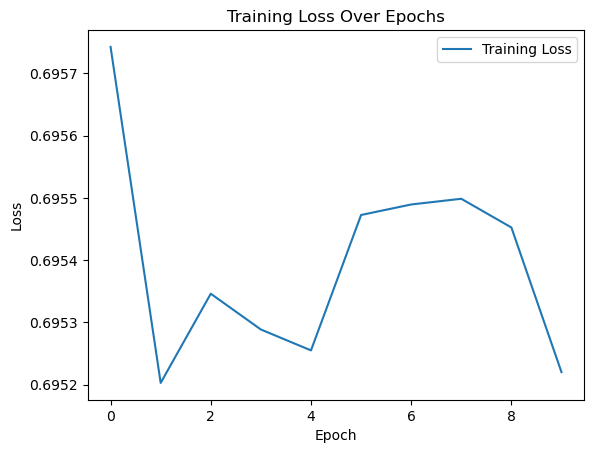

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class JetDataset(Dataset):
    def __init__(self, file_path):
        with h5py.File(file_path, 'r') as hdf:
            self.features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
            self.labels = torch.tensor(hdf["particles/labels"][:], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, ninp, nhead, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(ninp, 2)  # Assuming binary classification

    def forward(self, src, src_mask):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output.mean(dim=1))
        return output

def train():
    # dataset = JetDataset("../data/val/val_20_30.h5")
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = TransformerModel(ninp=128, nhead=2, nhid=200, nlayers=2, dropout=0.5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    losses = []

    for epoch in range(10):
        model.train()
        total_loss = 0.
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
        for data, targets in progress_bar:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(data, None)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

train()

In [ ]:
# Dataset Class
class JetDataset(Dataset):
    def __init__(self, file_path):
        with h5py.File(file_path, 'r') as hdf:
            self.features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
            self.labels = torch.tensor(hdf["particles/labels"][:], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.encoder = nn.Linear(ntoken, ninp)
        self.transformer = nn.Transformer(ninp, nhead, nlayers, nlayers, nhid, dropout)
        self.decoder = nn.Linear(ninp, ntoken)
        self.ninp = ninp  # Ensure ninp is correctly set as an instance variable
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = self.decoder(output)
        return output

# Training Function
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        total_loss = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(features)
            
            # Assuming output shape is [batch_size, seq_length, num_classes]
            # Select the output of the last timestep
            output = output[:, -1, :]  # shape now [batch_size, num_classes]
            
            # Ensure labels are of shape [batch_size]
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}: Loss: {total_loss / len(train_loader)}')


# Load and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = JetDataset("../data/val/val_20_30.h5")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

ntokens = int(dataset.features.size(-1))  # Size of the vocab
ninp = 200  # Embedding dimension
nhead = 2   # Number of heads in the multiheadattention models
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.5

model = TransformerModel(ntokens, ninp, nhead, nhid, nlayers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

train(model, dataloader, criterion, optimizer, 10)

Epochs:  10%|█████▍                                                | 1/10 [03:17<29:37, 197.49s/it]

Epoch 1: Loss: 0.7227946308864305


Epochs:  20%|██████████▊                                           | 2/10 [06:37<26:29, 198.71s/it]

Epoch 2: Loss: 0.6985211401387437


Epochs:  30%|████████████████▏                                     | 3/10 [09:52<23:00, 197.15s/it]

Epoch 3: Loss: 0.6937451358066393


Epochs:  30%|████████████████▏                                     | 3/10 [11:14<26:13, 224.85s/it]


KeyboardInterrupt: 

In [11]:
dataset = JetDataset("../data/val/val_20_30.h5")

In [ ]:
# Dataset Class with Augmentation and Subjet Information
class JetDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with h5py.File(file_path, 'r') as hdf:
            self.particles_features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
            self.subjets = hdf["subjets"][:]
        
        self.subjets = [json.loads(subjet) for subjet in self.subjets]
        self.transform = transform

    def __len__(self):
        return len(self.subjets)

    def __getitem__(self, idx):
        particles_features, subjets = self.particles_features[idx], self.subjets[idx]
        if self.transform:
            particles_features = self.transform(particles_features)
        return particles_features, subjets

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio, **kwargs):
        super().__init__()
        self.encoder = models.vit_b_16(pretrained=True)
        self.encoder.head = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

# Predictor Network
class Predictor(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio, **kwargs):
        super().__init__()
        self.encoder = models.vit_b_16(pretrained=True)
        self.encoder.head = nn.Identity()

    def forward(self, context, mask_tokens):
        x = torch.cat([context, mask_tokens], dim=1)
        return self.encoder(x)

# Joint-Embedding Predictive Architecture (I-JEPA)
class IJEPA(nn.Module):
    def __init__(self, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0):
        super().__init__()
        self.context_encoder = VisionTransformer(embed_dim, depth, num_heads, mlp_ratio)
        self.target_encoder = VisionTransformer(embed_dim, depth, num_heads, mlp_ratio)
        self.predictor = Predictor(embed_dim, depth, num_heads, mlp_ratio)

    def forward(self, context, target, mask_tokens):
        context_repr = self.context_encoder(context)
        target_repr = self.target_encoder(target)
        pred_repr = self.predictor(context_repr, mask_tokens)
        return pred_repr, target_repr

# Masking function
def mask_tokens(features, mask_ratio=0.15):
    mask = torch.rand(features.shape) < mask_ratio
    mask_tokens = features[mask].clone()
    features[mask] = 0
    return features, mask_tokens

# Preprocess subjets data to convert lists of dictionaries to tensors
def preprocess_subjets(subjets):
    processed_subjets = []
    for subjet in subjets:
        processed_subjet = []
        for key in subjet:
            component = torch.tensor(subjet[key], dtype=torch.float32)
            processed_subjet.append(component)
        processed_subjets.append(torch.stack(processed_subjet))
    
    return torch.stack(processed_subjets)

# Custom collate function for DataLoader
def custom_collate_fn(batch):
    particles_features = torch.stack([item[0] for item in batch])
    subjets = [item[1] for item in batch]
    return particles_features, subjets

# Training Function with Learning Rate Scheduler and Validation
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    model.train()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        total_loss = 0
        for particles_features, subjets in train_loader:
            particles_features = particles_features.to(device)
            subjets = preprocess_subjets(subjets).to(device)
            optimizer.zero_grad()

            # Mask tokens
            masked_features, mask_tokens = mask_tokens(particles_features)

            # Forward pass
            pred_repr, target_repr = model(masked_features, subjets, mask_tokens)
            loss = criterion(pred_repr, target_repr)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        scheduler.step()
        print(f'Epoch {epoch+1}: Loss: {total_loss / len(train_loader)}')

        # Validation
        validate(model, val_loader, criterion, device)

def validate(model, val_loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for particles_features, subjets in val_loader:
            particles_features = particles_features.to(device)
            subjets = preprocess_subjets(subjets).to(device)
            
            # Mask tokens
            masked_features, mask_tokens = mask_tokens(particles_features)

            # Forward pass
            pred_repr, target_repr = model(masked_features, subjets, mask_tokens)
            loss = criterion(pred_repr, target_repr)
            
            total_loss += loss.item()
    
    print(f'Validation Loss: {total_loss / len(val_loader)}')

# Load and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset and split into train and validation
# dataset = JetDataset("../data/val/val_20_30.h5")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

# model = IJEPA(embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0).to(device)
model = IJEPA(embed_dim=256, depth=6, num_heads=4, mlp_ratio=4.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.90 GiB total capacity; 9.54 GiB already allocated; 21.06 MiB free; 10.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Dataset Class with Augmentation and Subjet Information
class JetDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with h5py.File(file_path, 'r') as hdf:
            self.particles_features = torch.tensor(hdf["particles/features"][:], dtype=torch.float32)
            self.subjets = hdf["subjets"][:]
        
        self.subjets = [json.loads(subjet) for subjet in self.subjets]
        self.transform = transform

    def __len__(self):
        return len(self.subjets)

    def __getitem__(self, idx):
        particles_features, subjets = self.particles_features[idx], self.subjets[idx]
        if self.transform:
            particles_features = self.transform(particles_features)
        return particles_features, subjets

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Vision Transformer Model
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio, **kwargs):
        super().__init__()
        self.encoder = models.vit_b_16(pretrained=True)
        self.encoder.head = nn.Identity()

    def forward(self, x):
        return self.encoder(x)

# Predictor Network
class Predictor(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio, **kwargs):
        super().__init__()
        self.encoder = models.vit_b_16(pretrained=True)
        self.encoder.head = nn.Identity()

    def forward(self, context, mask_tokens):
        x = torch.cat([context, mask_tokens], dim=1)
        return self.encoder(x)

# Joint-Embedding Predictive Architecture (I-JEPA)
class IJEPA(nn.Module):
    def __init__(self, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0):
        super().__init__()
        self.context_encoder = VisionTransformer(embed_dim, depth, num_heads, mlp_ratio)
        self.target_encoder = VisionTransformer(embed_dim, depth, num_heads, mlp_ratio)
        self.predictor = Predictor(embed_dim, depth, num_heads, mlp_ratio)

    def forward(self, context, target, mask_tokens):
        context_repr = self.context_encoder(context)
        target_repr = self.target_encoder(target)
        pred_repr = self.predictor(context_repr, mask_tokens)
        return pred_repr, target_repr

# Masking function
def mask_tokens(features, mask_ratio=0.15):
    mask = torch.rand(features.shape) < mask_ratio
    mask_tokens = features[mask].clone()
    features[mask] = 0
    return features, mask_tokens

# Preprocess subjets data to convert lists of dictionaries to tensors
def preprocess_subjets(subjets):
    processed_subjets = []
    for subjet in subjets:
        processed_subjet = [torch.tensor(subjet[key], dtype=torch.float32) for key in subjet]
        processed_subjets.append(torch.stack(processed_subjet))
    
    return torch.stack(processed_subjets)

# Custom collate function for DataLoader
def custom_collate_fn(batch):
    particles_features = torch.stack([item[0] for item in batch])
    subjets = [item[1] for item in batch]
    return particles_features, subjets

# Training Function with Learning Rate Scheduler and Validation
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device='cpu'):
    model.train()
    scaler = amp.GradScaler()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        total_loss = 0
        for particles_features, subjets in train_loader:
            particles_features = particles_features.to(device)
            subjets = preprocess_subjets(subjets).to(device)
            optimizer.zero_grad()

            # Mask tokens
            masked_features, mask_tokens = mask_tokens(particles_features)

            # Forward pass with mixed precision
            with amp.autocast():
                pred_repr, target_repr = model(masked_features, subjets, mask_tokens)
                loss = criterion(pred_repr, target_repr)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
        
        scheduler.step()
        print(f'Epoch {epoch+1}: Loss: {total_loss / len(train_loader)}')

        # Validation
        validate(model, val_loader, criterion, device)

def validate(model, val_loader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for particles_features, subjets in val_loader:
            particles_features = particles_features.to(device)
            subjets = preprocess_subjets(subjets).to(device)
            
            # Mask tokens
            masked_features, mask_tokens = mask_tokens(particles_features)

            # Forward pass
            with amp.autocast():
                pred_repr, target_repr = model(masked_features, subjets, mask_tokens)
                loss = criterion(pred_repr, target_repr)
            
            total_loss += loss.item()
    
    print(f'Validation Loss: {total_loss / len(val_loader)}')

# Load and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset and split into train and validation
# dataset = JetDataset("../data/val/val_20_30.h5")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

model = IJEPA(embed_dim=384, depth=12, num_heads=6, mlp_ratio=4.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10, device=device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.90 GiB total capacity; 9.54 GiB already allocated; 21.06 MiB free; 10.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF